In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.argv=['']
del sys
os.chdir("../")

In [7]:
import matplotlib.pyplot as plt
import os
import json
import math
import torch
import logging
import numpy as np
import pandas as pd

from IPython import embed
from common import data_preprocess 
from common.utils import print_to_json
from common.dataloader import load_SMAP_MSL_dataset, load_CSV_dataset, load_SMD_dataset
from common.sliding import BatchSlidingWindow, WindowIterator
from common.config import parse_arguments, set_logger, initialize_config
from networks.mlstm import MultiLSTMEncoder
from torch import nn
# from pyts.approximation import SymbolicAggregateApproximation
# from saxpy.znorm import znorm
# from saxpy.paa import paa
# from saxpy.sax import ts_to_string
from gensim.models import Word2Vec

%matplotlib inline

In [8]:
# train
args = parse_arguments()

# load config
config_dir = "./hypers/" if not args["load"] else args["load"]
params = initialize_config(config_dir, args)
params["clear"] = 1
params["nrows"] = None

In [9]:
data_dict = load_SMD_dataset("./datasets/anomaly/SMD/processed", "machine-1-1", params.get("use_dim", "all"))
pp = data_preprocess.preprocessor()
pp.save(params["save_path"])
# data_dict = pp.normalize(data_dict,method="standard")
data_dict = pp.discretize(data_dict,n_bins=params.get("n_bins", "50"))
vocab_size = pp.build_vocab(data_dict)
vocab_size

2021-01-30 16:51:38,271 P92522 INFO Loading machine-1-1 dataset
2021-01-30 16:51:38,276 P92522 INFO Saving preprocessor into ./checkpoints/20210130-165138/preprocessor.pkl
2021-01-30 16:51:38,283 P92522 INFO # of Discretized tokens: 50


1 files found.


50

In [10]:
sentences = [list(item) for item in data_dict["train"].T.astype(str)]
model = Word2Vec(sentences=sentences, size=10, window=5, min_count=1, workers=4)
pretrain_mat = torch.FloatTensor(np.array([model.wv[str(i)] for i in range(vocab_size)]))
pretrain_mat.shape
# model.save("word2vec.model")

2021-01-30 16:51:38,475 P92522 WARNING consider setting layer size to a multiple of 4 for greater performance
2021-01-30 16:51:38,476 P92522 INFO collecting all words and their counts
2021-01-30 16:51:38,477 P92522 INFO PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-01-30 16:51:38,482 P92522 INFO collected 42 word types from a corpus of 28479 raw words and 1 sentences
2021-01-30 16:51:38,483 P92522 INFO Loading a fresh vocabulary
2021-01-30 16:51:38,484 P92522 INFO effective_min_count=1 retains 42 unique words (100% of original 42, drops 0)
2021-01-30 16:51:38,485 P92522 INFO effective_min_count=1 leaves 28479 word corpus (100% of original 28479, drops 0)
2021-01-30 16:51:38,486 P92522 INFO deleting the raw counts dictionary of 42 items
2021-01-30 16:51:38,487 P92522 INFO sample=0.001 downsamples 23 most-common words
2021-01-30 16:51:38,488 P92522 INFO downsampling leaves estimated 4835 word corpus (17.0% of prior 28479)
2021-01-30 16:51:38,489 P92522 INFO estim

KeyError: "word '38' not in vocabulary"

In [11]:
window_dict = data_preprocess.generate_windows(data_dict, data_hdf5_path=params["path"], **params)

2021-01-30 16:51:39,396 P92522 INFO Generating sliding windows (size 5).
2021-01-30 16:51:39,453 P92522 INFO Train windows #: (5695, 5, 1)
2021-01-30 16:51:39,454 P92522 INFO Test windows #: (28474, 5, 1)


In [12]:
window_dict["train_windows"][6]

array([[3.],
       [1.],
       [1.],
       [8.],
       [6.]], dtype=float32)

In [16]:
train_iterator = WindowIterator(window_dict["train_windows"][0:5], batch_size=params["batch_size"], shuffle=True)
test_iterator = WindowIterator(window_dict["test_windows"], batch_size=params["batch_size"], shuffle=False)
params['in_channels'] = data_dict["dim"]
params["embedding_dim"] = 32
params["lr"] = 1.0e-3

In [17]:
encoder = MultiLSTMEncoder(vocab_size=vocab_size, pretrain_mat=None, **params)

2021-01-30 16:58:21,964 P92522 INFO Compiling finished.


In [19]:
window_dict["train_windows"][0:5]

array([[[4.],
        [5.],
        [4.],
        [3.],
        [2.]],

       [[0.],
        [1.],
        [2.],
        [3.],
        [3.]],

       [[1.],
        [2.],
        [4.],
        [2.],
        [0.]],

       [[2.],
        [4.],
        [2.],
        [1.],
        [3.]],

       [[6.],
        [4.],
        [2.],
        [4.],
        [5.]]], dtype=float32)

2021-01-30 16:58:22,227 P92522 INFO Start training for 1 batches.
2021-01-30 16:58:22,257 P92522 INFO ploss: 0.4314, nloss: 1.0511, pos: 0.8969, neg: 0.5921


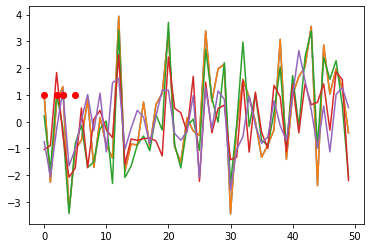

2021-01-30 16:58:22,453 P92522 INFO acc: 0.0
2021-01-30 16:58:22,463 P92522 INFO Epoch: 1, loss: 0.431
2021-01-30 16:58:22,491 P92522 INFO ploss: 0.2009, nloss: 1.1553, pos: 1.6317, neg: 0.6408


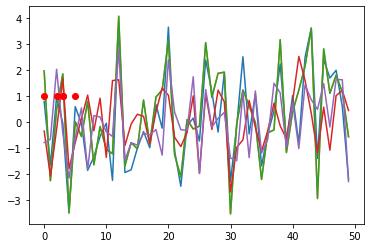

2021-01-30 16:58:22,678 P92522 INFO acc: 0.0
2021-01-30 16:58:22,688 P92522 INFO Epoch: 2, loss: 0.201
2021-01-30 16:58:22,715 P92522 INFO ploss: 0.0939, nloss: 0.7715, pos: 2.3617, neg: 0.1117


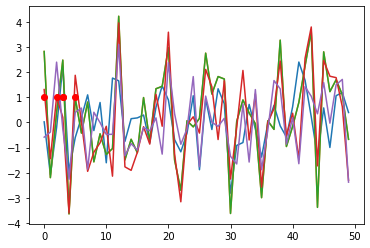

2021-01-30 16:58:22,937 P92522 INFO acc: 0.0
2021-01-30 16:58:22,948 P92522 INFO Epoch: 3, loss: 0.094
2021-01-30 16:58:22,971 P92522 INFO ploss: 0.0472, nloss: 1.1668, pos: 3.0628, neg: 0.6339


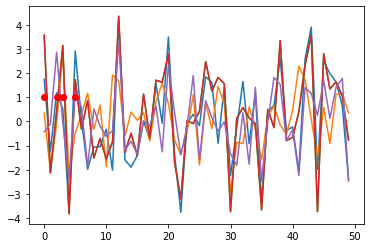

2021-01-30 16:58:23,179 P92522 INFO acc: 0.2
2021-01-30 16:58:23,191 P92522 INFO Epoch: 4, loss: 0.047
2021-01-30 16:58:23,220 P92522 INFO ploss: 0.0252, nloss: 1.0161, pos: 3.7153, neg: 0.5372


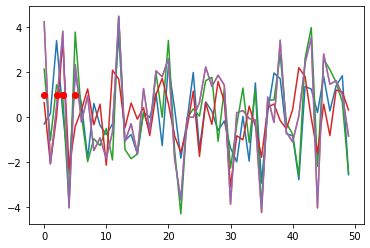

2021-01-30 16:58:23,416 P92522 INFO acc: 0.2
2021-01-30 16:58:23,424 P92522 INFO Epoch: 5, loss: 0.025
2021-01-30 16:58:23,451 P92522 INFO ploss: 0.0142, nloss: 0.9873, pos: 4.3124, neg: 0.4554


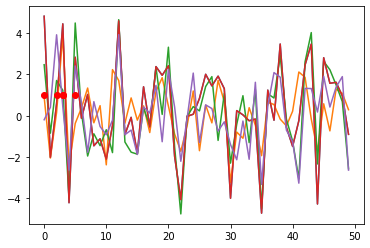

2021-01-30 16:58:23,742 P92522 INFO acc: 0.4
2021-01-30 16:58:23,751 P92522 INFO Epoch: 6, loss: 0.014
2021-01-30 16:58:23,781 P92522 INFO ploss: 0.0084, nloss: 0.8614, pos: 4.8542, neg: 0.0775


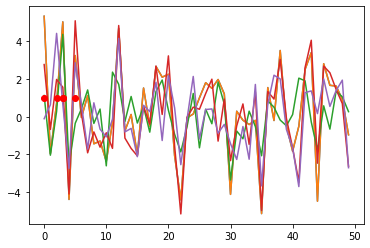

2021-01-30 16:58:23,967 P92522 INFO acc: 0.8
2021-01-30 16:58:23,978 P92522 INFO Epoch: 7, loss: 0.008
2021-01-30 16:58:24,007 P92522 INFO ploss: 0.0052, nloss: 1.0837, pos: 5.3441, neg: 0.3390


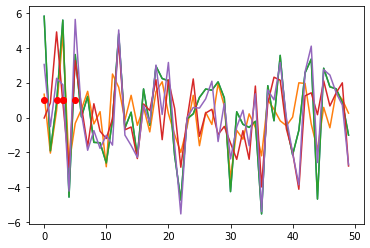

2021-01-30 16:58:24,183 P92522 INFO acc: 0.8
2021-01-30 16:58:24,191 P92522 INFO Epoch: 8, loss: 0.005
2021-01-30 16:58:24,217 P92522 INFO ploss: 0.0033, nloss: 0.9095, pos: 5.7866, neg: 0.1331


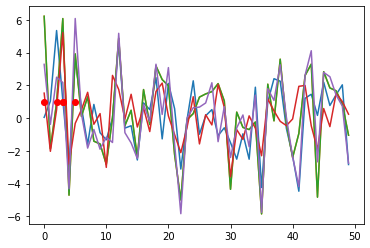

2021-01-30 16:58:24,386 P92522 INFO acc: 0.8
2021-01-30 16:58:24,396 P92522 INFO Epoch: 9, loss: 0.003
2021-01-30 16:58:24,423 P92522 INFO ploss: 0.0023, nloss: 1.3610, pos: 6.1863, neg: 1.0023


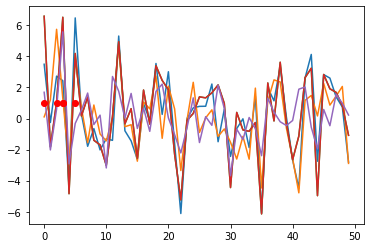

2021-01-30 16:58:24,619 P92522 INFO acc: 0.8
2021-01-30 16:58:24,629 P92522 INFO Epoch: 10, loss: 0.002
2021-01-30 16:58:24,655 P92522 INFO ploss: 0.0016, nloss: 1.1631, pos: 6.5475, neg: 0.7277


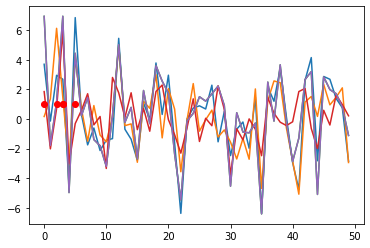

2021-01-30 16:58:24,846 P92522 INFO acc: 0.8
2021-01-30 16:58:24,855 P92522 INFO Epoch: 11, loss: 0.002
2021-01-30 16:58:24,880 P92522 INFO ploss: 0.0011, nloss: 0.9203, pos: 6.8742, neg: 0.3739


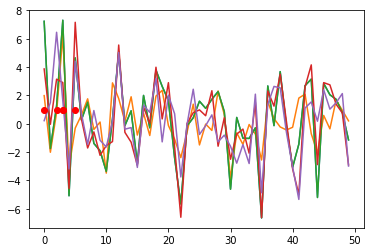

2021-01-30 16:58:25,049 P92522 INFO acc: 0.8
2021-01-30 16:58:25,059 P92522 INFO Epoch: 12, loss: 0.001
2021-01-30 16:58:25,087 P92522 INFO ploss: 0.0009, nloss: 0.5765, pos: 7.1699, neg: -0.4928


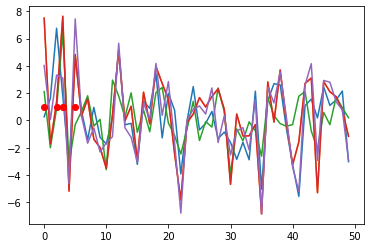

2021-01-30 16:58:25,286 P92522 INFO acc: 0.8
2021-01-30 16:58:25,297 P92522 INFO Epoch: 13, loss: 0.001
2021-01-30 16:58:25,325 P92522 INFO ploss: 0.0007, nloss: 1.0709, pos: 7.4376, neg: 0.3093


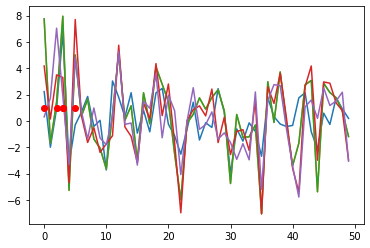

2021-01-30 16:58:25,519 P92522 INFO acc: 0.8
2021-01-30 16:58:25,528 P92522 INFO Epoch: 14, loss: 0.001
2021-01-30 16:58:25,554 P92522 INFO ploss: 0.0005, nloss: 0.8458, pos: 7.6800, neg: -0.2825


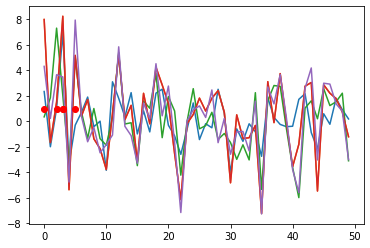

2021-01-30 16:58:25,723 P92522 INFO acc: 0.8
2021-01-30 16:58:25,732 P92522 INFO Epoch: 15, loss: 0.001
2021-01-30 16:58:25,759 P92522 INFO ploss: 0.0004, nloss: 1.1525, pos: 7.8997, neg: 0.6758


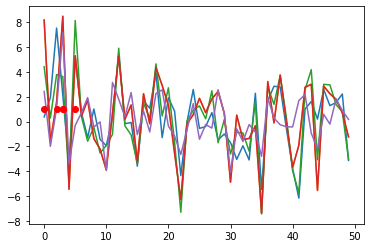

2021-01-30 16:58:25,941 P92522 INFO acc: 0.8
2021-01-30 16:58:25,951 P92522 INFO Epoch: 16, loss: 0.000
2021-01-30 16:58:25,978 P92522 INFO ploss: 0.0003, nloss: 1.0412, pos: 8.0986, neg: 0.2757


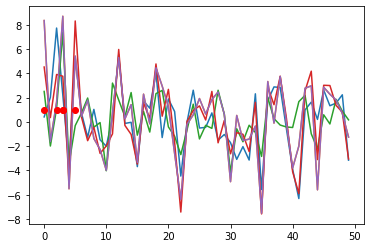

2021-01-30 16:58:26,181 P92522 INFO acc: 0.8
2021-01-30 16:58:26,192 P92522 INFO Epoch: 17, loss: 0.000
2021-01-30 16:58:26,219 P92522 INFO ploss: 0.0003, nloss: 0.8919, pos: 8.2788, neg: -0.3194


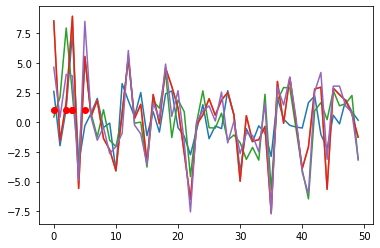

2021-01-30 16:58:26,390 P92522 INFO acc: 0.8
2021-01-30 16:58:26,400 P92522 INFO Epoch: 18, loss: 0.000
2021-01-30 16:58:26,429 P92522 INFO ploss: 0.0002, nloss: 1.0243, pos: 8.4420, neg: 0.1374


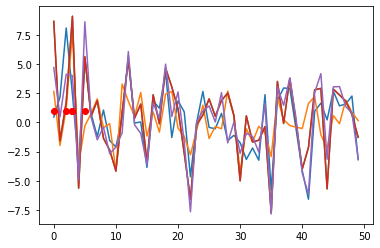

2021-01-30 16:58:26,628 P92522 INFO acc: 0.8
2021-01-30 16:58:26,638 P92522 INFO Epoch: 19, loss: 0.000
2021-01-30 16:58:26,667 P92522 INFO ploss: 0.0002, nloss: 1.5123, pos: 8.5895, neg: 0.7177


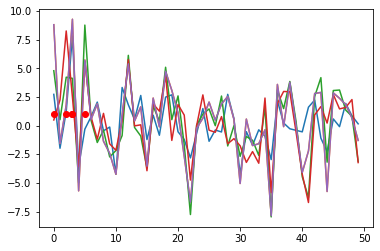

2021-01-30 16:58:26,866 P92522 INFO acc: 0.8
2021-01-30 16:58:26,876 P92522 INFO Epoch: 20, loss: 0.000
2021-01-30 16:58:26,901 P92522 INFO ploss: 0.0002, nloss: 0.9394, pos: 8.7230, neg: 0.3921


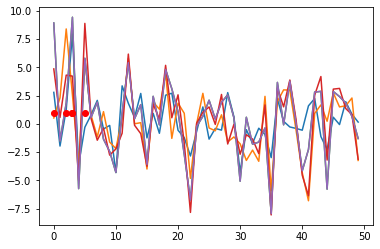

2021-01-30 16:58:27,219 P92522 INFO acc: 0.8
2021-01-30 16:58:27,230 P92522 INFO Epoch: 21, loss: 0.000
2021-01-30 16:58:27,257 P92522 INFO ploss: 0.0002, nloss: 1.4071, pos: 8.8435, neg: 0.8084


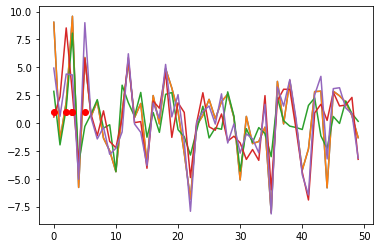

2021-01-30 16:58:27,450 P92522 INFO acc: 0.8
2021-01-30 16:58:27,461 P92522 INFO Epoch: 22, loss: 0.000
2021-01-30 16:58:27,489 P92522 INFO ploss: 0.0001, nloss: 1.1300, pos: 8.9523, neg: -0.2677


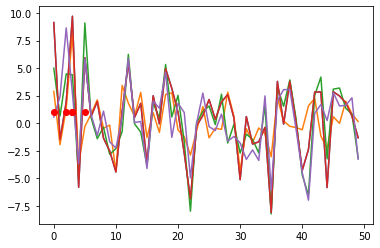

2021-01-30 16:58:27,663 P92522 INFO acc: 0.8
2021-01-30 16:58:27,671 P92522 INFO Epoch: 23, loss: 0.000
2021-01-30 16:58:27,699 P92522 INFO ploss: 0.0001, nloss: 0.9691, pos: 9.0503, neg: 0.1412


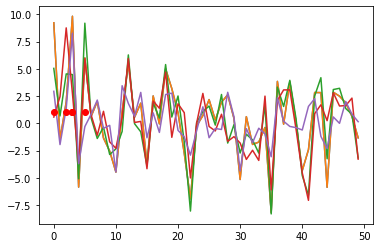

2021-01-30 16:58:27,864 P92522 INFO acc: 0.8
2021-01-30 16:58:27,875 P92522 INFO Epoch: 24, loss: 0.000
2021-01-30 16:58:27,901 P92522 INFO ploss: 0.0001, nloss: 0.5985, pos: 9.1385, neg: -0.5382


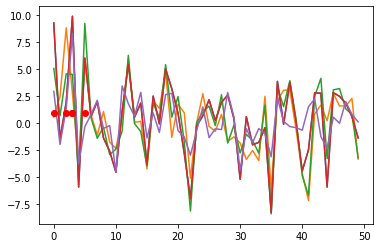

2021-01-30 16:58:28,071 P92522 INFO acc: 0.8
2021-01-30 16:58:28,080 P92522 INFO Epoch: 25, loss: 0.000
2021-01-30 16:58:28,110 P92522 INFO ploss: 0.0001, nloss: 1.9693, pos: 9.2178, neg: 1.5965


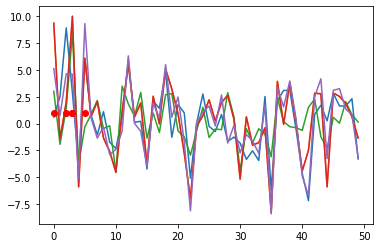

2021-01-30 16:58:28,309 P92522 INFO acc: 0.8
2021-01-30 16:58:28,318 P92522 INFO Epoch: 26, loss: 0.000
2021-01-30 16:58:28,345 P92522 INFO ploss: 0.0001, nloss: 1.4340, pos: 9.2888, neg: 0.9900


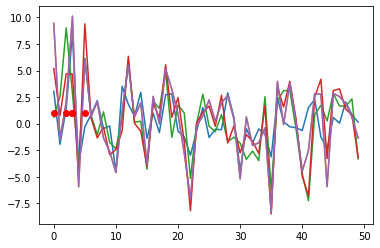

2021-01-30 16:58:28,523 P92522 INFO acc: 0.8
2021-01-30 16:58:28,534 P92522 INFO Epoch: 27, loss: 0.000
2021-01-30 16:58:28,562 P92522 INFO ploss: 0.0001, nloss: 0.8203, pos: 9.3524, neg: -0.2646


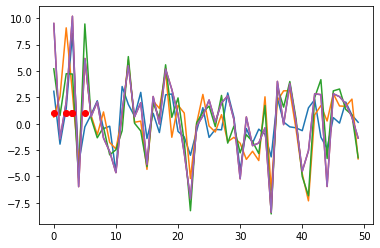

2021-01-30 16:58:28,737 P92522 INFO acc: 0.8
2021-01-30 16:58:28,746 P92522 INFO Epoch: 28, loss: 0.000
2021-01-30 16:58:28,772 P92522 INFO ploss: 0.0001, nloss: 1.0479, pos: 9.4091, neg: 0.0993


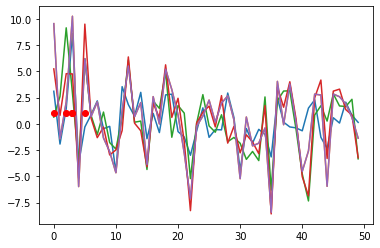

2021-01-30 16:58:28,965 P92522 INFO acc: 0.8
2021-01-30 16:58:28,976 P92522 INFO Epoch: 29, loss: 0.000
2021-01-30 16:58:29,004 P92522 INFO ploss: 0.0001, nloss: 0.9558, pos: 9.4596, neg: 0.1949


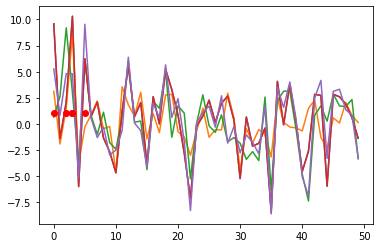

2021-01-30 16:58:29,198 P92522 INFO acc: 0.8
2021-01-30 16:58:29,208 P92522 INFO Epoch: 30, loss: 0.000
2021-01-30 16:58:29,234 P92522 INFO ploss: 0.0001, nloss: 1.3400, pos: 9.5043, neg: 0.7866


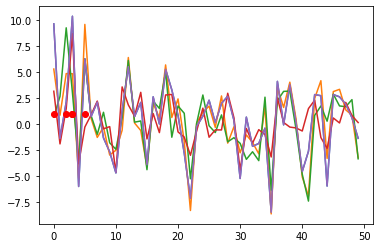

2021-01-30 16:58:29,431 P92522 INFO acc: 0.8
2021-01-30 16:58:29,440 P92522 INFO Epoch: 31, loss: 0.000
2021-01-30 16:58:29,465 P92522 INFO ploss: 0.0001, nloss: 0.9607, pos: 9.5438, neg: 0.1150


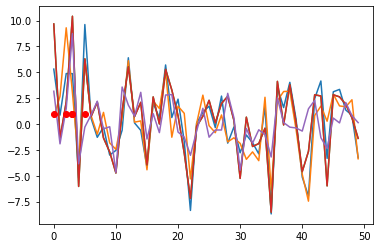

2021-01-30 16:58:29,664 P92522 INFO acc: 0.8
2021-01-30 16:58:29,674 P92522 INFO Epoch: 32, loss: 0.000
2021-01-30 16:58:29,699 P92522 INFO ploss: 0.0001, nloss: 1.2109, pos: 9.5785, neg: 0.7667


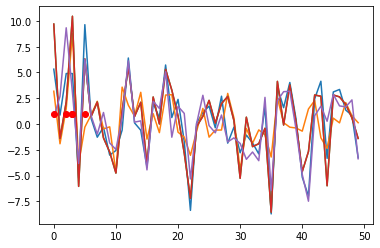

2021-01-30 16:58:29,867 P92522 INFO acc: 0.8
2021-01-30 16:58:29,878 P92522 INFO Epoch: 33, loss: 0.000
2021-01-30 16:58:29,905 P92522 INFO ploss: 0.0001, nloss: 0.4106, pos: 9.6088, neg: -0.9140


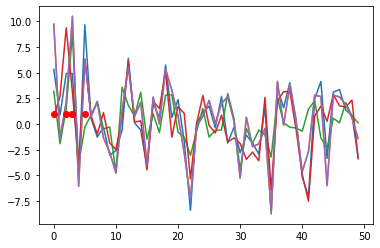

2021-01-30 16:58:30,081 P92522 INFO acc: 0.8
2021-01-30 16:58:30,091 P92522 INFO Epoch: 34, loss: 0.000
2021-01-30 16:58:30,118 P92522 INFO ploss: 0.0001, nloss: 0.3143, pos: 9.6351, neg: -1.4809


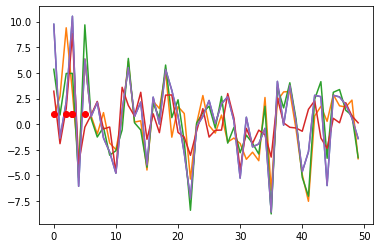

2021-01-30 16:58:30,281 P92522 INFO acc: 0.8
2021-01-30 16:58:30,290 P92522 INFO Epoch: 35, loss: 0.000
2021-01-30 16:58:30,317 P92522 INFO ploss: 0.0001, nloss: 1.1795, pos: 9.6578, neg: -0.0208


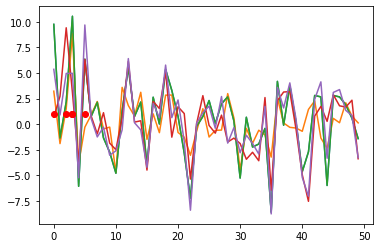

2021-01-30 16:58:30,644 P92522 INFO acc: 0.8
2021-01-30 16:58:30,654 P92522 INFO Epoch: 36, loss: 0.000
2021-01-30 16:58:30,684 P92522 INFO ploss: 0.0001, nloss: 1.4184, pos: 9.6772, neg: 0.4554


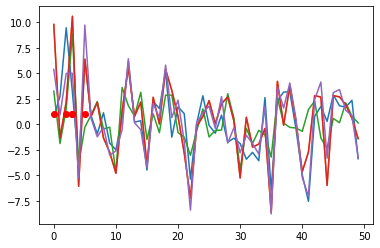

2021-01-30 16:58:30,852 P92522 INFO acc: 0.8
2021-01-30 16:58:30,865 P92522 INFO Epoch: 37, loss: 0.000
2021-01-30 16:58:30,892 P92522 INFO ploss: 0.0001, nloss: 1.4711, pos: 9.6934, neg: 1.0020


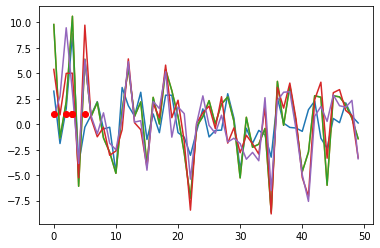

2021-01-30 16:58:31,065 P92522 INFO acc: 0.8
2021-01-30 16:58:31,076 P92522 INFO Epoch: 38, loss: 0.000
2021-01-30 16:58:31,105 P92522 INFO ploss: 0.0001, nloss: 1.8496, pos: 9.7069, neg: 1.1791


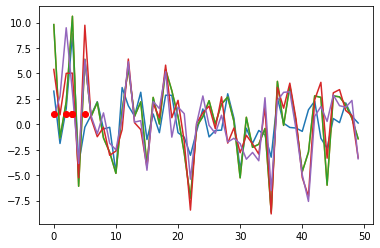

2021-01-30 16:58:31,301 P92522 INFO acc: 0.8
2021-01-30 16:58:31,310 P92522 INFO Epoch: 39, loss: 0.000
2021-01-30 16:58:31,337 P92522 INFO ploss: 0.0001, nloss: 0.6196, pos: 9.7179, neg: -0.4884


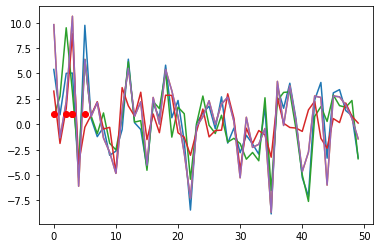

2021-01-30 16:58:31,521 P92522 INFO acc: 0.8
2021-01-30 16:58:31,531 P92522 INFO Epoch: 40, loss: 0.000
2021-01-30 16:58:31,557 P92522 INFO ploss: 0.0001, nloss: 1.4147, pos: 9.7265, neg: 0.8887


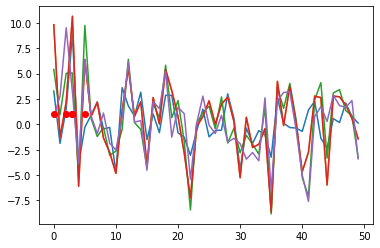

2021-01-30 16:58:31,729 P92522 INFO acc: 0.8
2021-01-30 16:58:31,738 P92522 INFO Epoch: 41, loss: 0.000
2021-01-30 16:58:31,764 P92522 INFO ploss: 0.0001, nloss: 1.3913, pos: 9.7331, neg: 0.9691


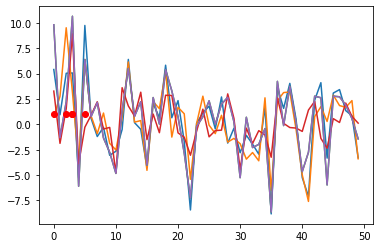

2021-01-30 16:58:31,938 P92522 INFO acc: 0.8
2021-01-30 16:58:31,948 P92522 INFO Epoch: 42, loss: 0.000
2021-01-30 16:58:31,976 P92522 INFO ploss: 0.0001, nloss: 0.8591, pos: 9.7376, neg: 0.1715


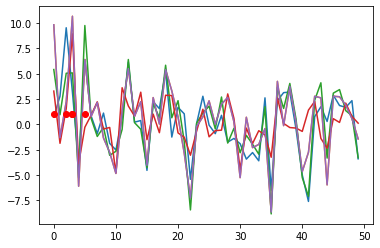

2021-01-30 16:58:32,155 P92522 INFO acc: 0.8
2021-01-30 16:58:32,166 P92522 INFO Epoch: 43, loss: 0.000
2021-01-30 16:58:32,204 P92522 INFO ploss: 0.0001, nloss: 1.4064, pos: 9.7405, neg: 0.6770


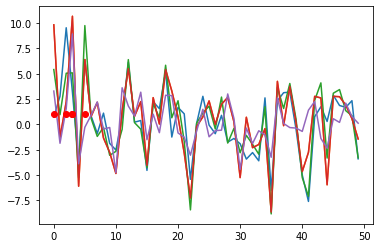

2021-01-30 16:58:32,378 P92522 INFO acc: 0.8
2021-01-30 16:58:32,387 P92522 INFO Epoch: 44, loss: 0.000
2021-01-30 16:58:32,418 P92522 INFO ploss: 0.0001, nloss: 1.0990, pos: 9.7417, neg: 0.5538


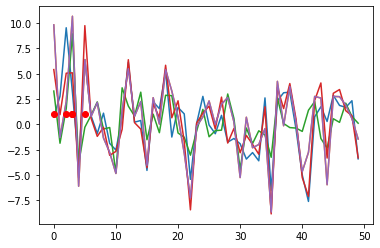

2021-01-30 16:58:32,583 P92522 INFO acc: 0.8
2021-01-30 16:58:32,594 P92522 INFO Epoch: 45, loss: 0.000
2021-01-30 16:58:32,620 P92522 INFO ploss: 0.0001, nloss: 1.3626, pos: 9.7414, neg: 0.8941


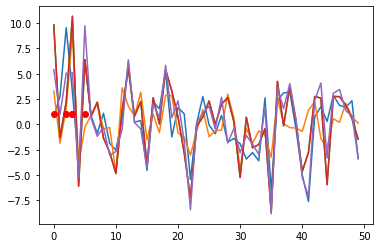

2021-01-30 16:58:32,821 P92522 INFO acc: 0.8
2021-01-30 16:58:32,831 P92522 INFO Epoch: 46, loss: 0.000
2021-01-30 16:58:32,864 P92522 INFO ploss: 0.0001, nloss: 1.4672, pos: 9.7398, neg: 0.8077


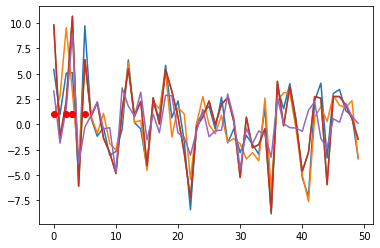

2021-01-30 16:58:33,074 P92522 INFO acc: 0.8
2021-01-30 16:58:33,085 P92522 INFO Epoch: 47, loss: 0.000
2021-01-30 16:58:33,112 P92522 INFO ploss: 0.0001, nloss: 0.7016, pos: 9.7370, neg: -0.3956


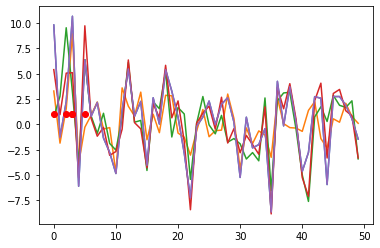

2021-01-30 16:58:33,295 P92522 INFO acc: 0.8
2021-01-30 16:58:33,307 P92522 INFO Epoch: 48, loss: 0.000
2021-01-30 16:58:33,336 P92522 INFO ploss: 0.0001, nloss: 1.3461, pos: 9.7330, neg: 0.6311


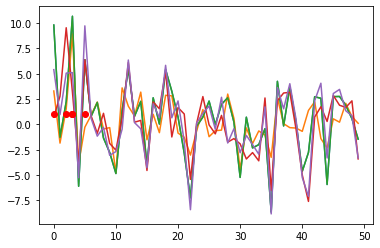

2021-01-30 16:58:33,508 P92522 INFO acc: 0.8
2021-01-30 16:58:33,519 P92522 INFO Epoch: 49, loss: 0.000
2021-01-30 16:58:33,547 P92522 INFO ploss: 0.0001, nloss: 1.1505, pos: 9.7281, neg: 0.5212


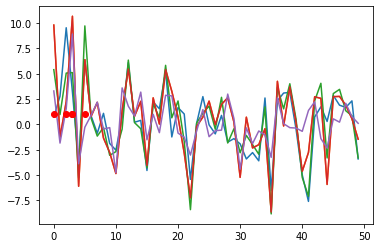

2021-01-30 16:58:33,720 P92522 INFO acc: 0.8
2021-01-30 16:58:33,731 P92522 INFO Epoch: 50, loss: 0.000
2021-01-30 16:58:33,758 P92522 INFO ploss: 0.0001, nloss: 0.7784, pos: 9.7222, neg: -0.0516


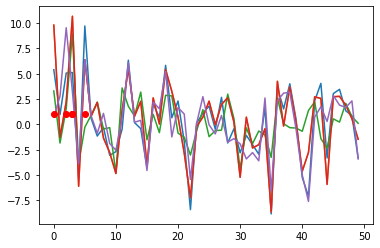

2021-01-30 16:58:34,067 P92522 INFO acc: 0.8
2021-01-30 16:58:34,078 P92522 INFO Epoch: 51, loss: 0.000
2021-01-30 16:58:34,107 P92522 INFO ploss: 0.0001, nloss: 1.0154, pos: 9.7155, neg: 0.1175


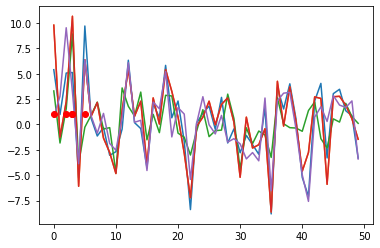

2021-01-30 16:58:34,282 P92522 INFO acc: 0.8
2021-01-30 16:58:34,295 P92522 INFO Epoch: 52, loss: 0.000
2021-01-30 16:58:34,322 P92522 INFO ploss: 0.0001, nloss: 1.2457, pos: 9.7081, neg: 0.6858


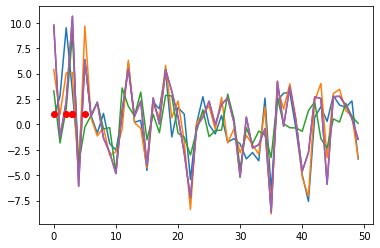

2021-01-30 16:58:34,490 P92522 INFO acc: 0.8
2021-01-30 16:58:34,499 P92522 INFO Epoch: 53, loss: 0.000
2021-01-30 16:58:34,526 P92522 INFO ploss: 0.0001, nloss: 0.9097, pos: 9.6999, neg: 0.2018


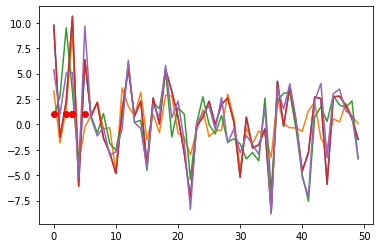

2021-01-30 16:58:34,697 P92522 INFO acc: 0.8
2021-01-30 16:58:34,707 P92522 INFO Epoch: 54, loss: 0.000
2021-01-30 16:58:34,734 P92522 INFO ploss: 0.0001, nloss: 1.3225, pos: 9.6911, neg: 0.6854


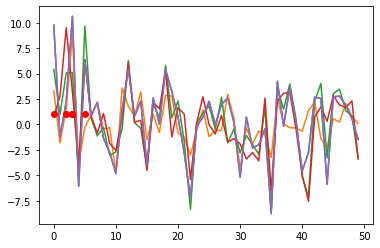

2021-01-30 16:58:34,901 P92522 INFO acc: 0.8
2021-01-30 16:58:34,910 P92522 INFO Epoch: 55, loss: 0.000
2021-01-30 16:58:34,937 P92522 INFO ploss: 0.0001, nloss: 0.7825, pos: 9.6817, neg: -0.2946


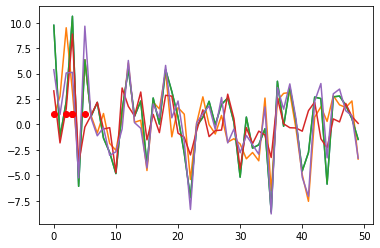

2021-01-30 16:58:35,104 P92522 INFO acc: 0.8
2021-01-30 16:58:35,114 P92522 INFO Epoch: 56, loss: 0.000
2021-01-30 16:58:35,141 P92522 INFO ploss: 0.0001, nloss: 2.3935, pos: 9.6719, neg: 1.9628


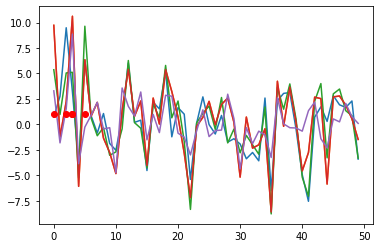

2021-01-30 16:58:35,329 P92522 INFO acc: 0.8
2021-01-30 16:58:35,340 P92522 INFO Epoch: 57, loss: 0.000
2021-01-30 16:58:35,366 P92522 INFO ploss: 0.0001, nloss: 1.1645, pos: 9.6615, neg: 0.3619


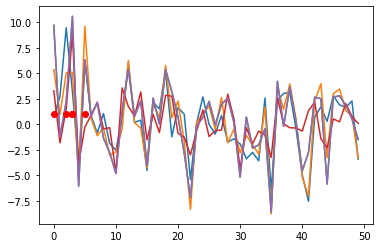

2021-01-30 16:58:35,551 P92522 INFO acc: 0.8
2021-01-30 16:58:35,560 P92522 INFO Epoch: 58, loss: 0.000
2021-01-30 16:58:35,586 P92522 INFO ploss: 0.0001, nloss: 1.0555, pos: 9.6507, neg: 0.4940


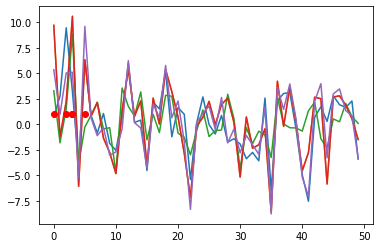

2021-01-30 16:58:35,755 P92522 INFO acc: 0.8
2021-01-30 16:58:35,765 P92522 INFO Epoch: 59, loss: 0.000
2021-01-30 16:58:35,791 P92522 INFO ploss: 0.0001, nloss: 0.9477, pos: 9.6395, neg: 0.1855


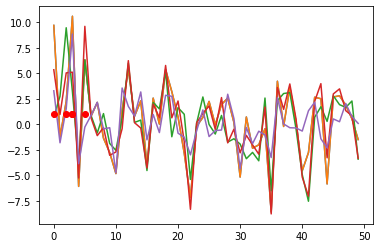

2021-01-30 16:58:35,958 P92522 INFO acc: 0.8
2021-01-30 16:58:35,968 P92522 INFO Epoch: 60, loss: 0.000
2021-01-30 16:58:35,994 P92522 INFO ploss: 0.0001, nloss: 1.1165, pos: 9.6280, neg: 0.5828


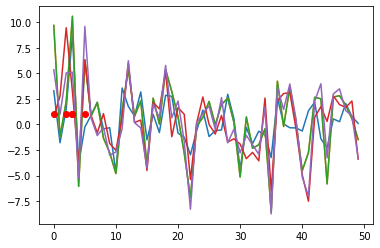

2021-01-30 16:58:36,161 P92522 INFO acc: 0.8
2021-01-30 16:58:36,171 P92522 INFO Epoch: 61, loss: 0.000
2021-01-30 16:58:36,198 P92522 INFO ploss: 0.0001, nloss: 0.5685, pos: 9.6162, neg: -0.5621


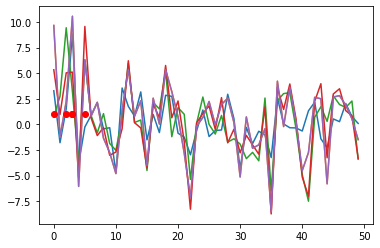

2021-01-30 16:58:36,363 P92522 INFO acc: 0.8
2021-01-30 16:58:36,372 P92522 INFO Epoch: 62, loss: 0.000
2021-01-30 16:58:36,401 P92522 INFO ploss: 0.0001, nloss: 0.9915, pos: 9.6041, neg: 0.0666


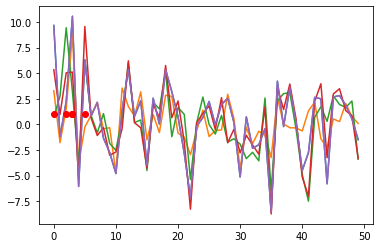

2021-01-30 16:58:36,568 P92522 INFO acc: 0.8
2021-01-30 16:58:36,578 P92522 INFO Epoch: 63, loss: 0.000
2021-01-30 16:58:36,605 P92522 INFO ploss: 0.0001, nloss: 0.5957, pos: 9.5917, neg: -0.6143


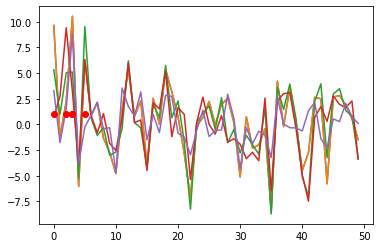

2021-01-30 16:58:36,772 P92522 INFO acc: 0.8
2021-01-30 16:58:36,783 P92522 INFO Epoch: 64, loss: 0.000
2021-01-30 16:58:36,809 P92522 INFO ploss: 0.0001, nloss: 1.0050, pos: 9.5791, neg: 0.0620


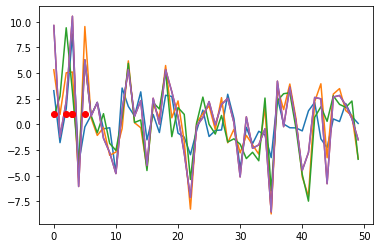

2021-01-30 16:58:36,976 P92522 INFO acc: 0.8
2021-01-30 16:58:36,985 P92522 INFO Epoch: 65, loss: 0.000
2021-01-30 16:58:37,012 P92522 INFO ploss: 0.0001, nloss: 1.4783, pos: 9.5663, neg: 0.7447


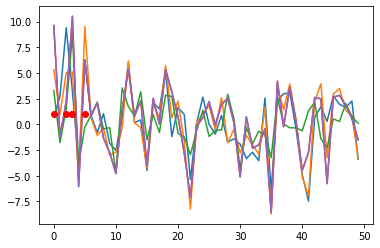

2021-01-30 16:58:37,293 P92522 INFO acc: 0.8
2021-01-30 16:58:37,302 P92522 INFO Epoch: 66, loss: 0.000
2021-01-30 16:58:37,329 P92522 INFO ploss: 0.0001, nloss: 0.8878, pos: 9.5533, neg: 0.2089


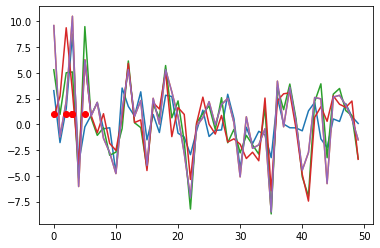

2021-01-30 16:58:37,500 P92522 INFO acc: 0.8
2021-01-30 16:58:37,512 P92522 INFO Epoch: 67, loss: 0.000
2021-01-30 16:58:37,538 P92522 INFO ploss: 0.0001, nloss: 1.3487, pos: 9.5401, neg: 0.9568


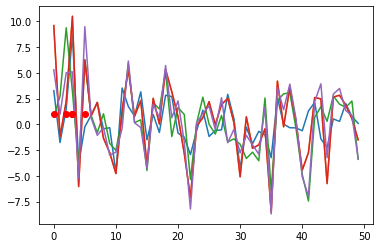

2021-01-30 16:58:37,707 P92522 INFO acc: 0.8
2021-01-30 16:58:37,715 P92522 INFO Epoch: 68, loss: 0.000
2021-01-30 16:58:37,742 P92522 INFO ploss: 0.0001, nloss: 0.9227, pos: 9.5268, neg: 0.3384


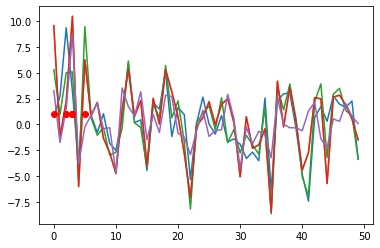

2021-01-30 16:58:37,911 P92522 INFO acc: 0.8
2021-01-30 16:58:37,922 P92522 INFO Epoch: 69, loss: 0.000
2021-01-30 16:58:37,948 P92522 INFO ploss: 0.0001, nloss: 1.7725, pos: 9.5133, neg: 1.4340


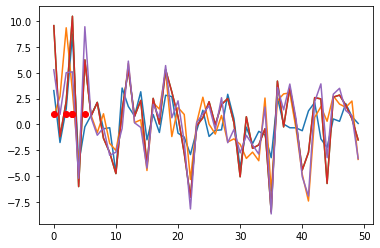

2021-01-30 16:58:38,114 P92522 INFO acc: 0.8
2021-01-30 16:58:38,124 P92522 INFO Epoch: 70, loss: 0.000
2021-01-30 16:58:38,151 P92522 INFO ploss: 0.0001, nloss: 0.7482, pos: 9.4998, neg: -0.1398


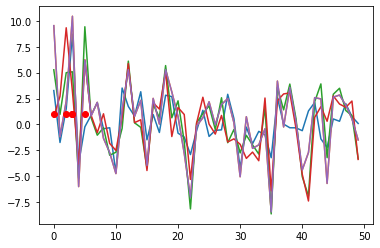

2021-01-30 16:58:38,323 P92522 INFO acc: 0.8
2021-01-30 16:58:38,333 P92522 INFO Epoch: 71, loss: 0.000
2021-01-30 16:58:38,362 P92522 INFO ploss: 0.0001, nloss: 0.7031, pos: 9.4861, neg: 0.0015


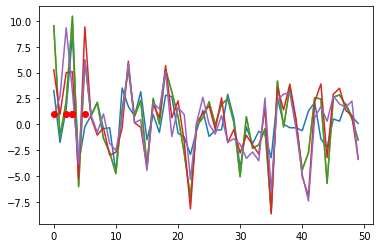

2021-01-30 16:58:38,531 P92522 INFO acc: 0.8
2021-01-30 16:58:38,541 P92522 INFO Epoch: 72, loss: 0.000
2021-01-30 16:58:38,569 P92522 INFO ploss: 0.0001, nloss: 0.7319, pos: 9.4723, neg: -0.4330


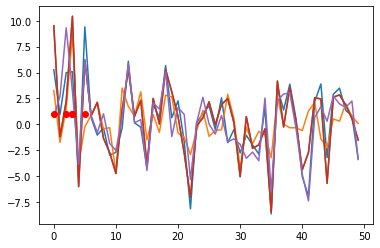

2021-01-30 16:58:38,736 P92522 INFO acc: 0.8
2021-01-30 16:58:38,745 P92522 INFO Epoch: 73, loss: 0.000
2021-01-30 16:58:38,772 P92522 INFO ploss: 0.0001, nloss: 1.1709, pos: 9.4585, neg: -0.0828


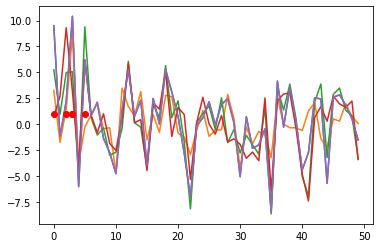

2021-01-30 16:58:38,938 P92522 INFO acc: 0.8
2021-01-30 16:58:38,948 P92522 INFO Epoch: 74, loss: 0.000
2021-01-30 16:58:38,973 P92522 INFO ploss: 0.0001, nloss: 0.8338, pos: 9.4446, neg: -0.4459


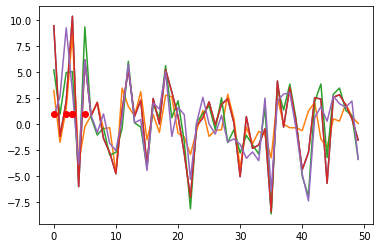

2021-01-30 16:58:39,141 P92522 INFO acc: 0.8
2021-01-30 16:58:39,150 P92522 INFO Epoch: 75, loss: 0.000
2021-01-30 16:58:39,176 P92522 INFO ploss: 0.0001, nloss: 1.2778, pos: 9.4307, neg: 0.5090


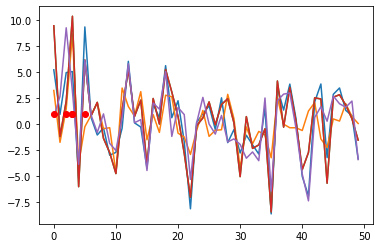

2021-01-30 16:58:39,345 P92522 INFO acc: 0.8
2021-01-30 16:58:39,354 P92522 INFO Epoch: 76, loss: 0.000
2021-01-30 16:58:39,381 P92522 INFO ploss: 0.0001, nloss: 1.1512, pos: 9.4166, neg: -0.0268


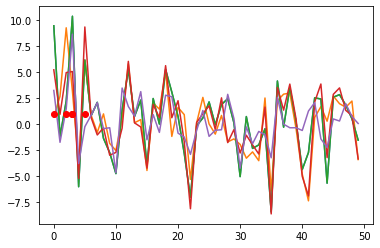

2021-01-30 16:58:39,546 P92522 INFO acc: 0.8
2021-01-30 16:58:39,556 P92522 INFO Epoch: 77, loss: 0.000
2021-01-30 16:58:39,583 P92522 INFO ploss: 0.0001, nloss: 1.1965, pos: 9.4026, neg: 0.2348


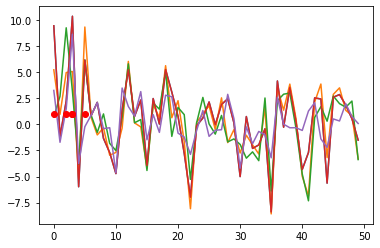

2021-01-30 16:58:39,767 P92522 INFO acc: 0.8
2021-01-30 16:58:39,778 P92522 INFO Epoch: 78, loss: 0.000
2021-01-30 16:58:39,805 P92522 INFO ploss: 0.0001, nloss: 0.8527, pos: 9.3885, neg: 0.1343


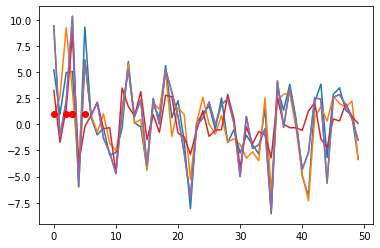

2021-01-30 16:58:39,995 P92522 INFO acc: 0.8
2021-01-30 16:58:40,004 P92522 INFO Epoch: 79, loss: 0.000
2021-01-30 16:58:40,031 P92522 INFO ploss: 0.0001, nloss: 1.0396, pos: 9.3744, neg: 0.2847


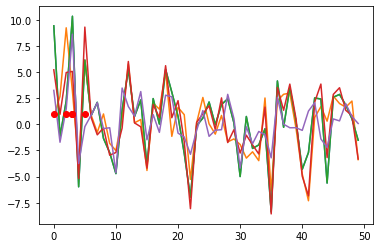

2021-01-30 16:58:40,217 P92522 INFO acc: 0.8
2021-01-30 16:58:40,227 P92522 INFO Epoch: 80, loss: 0.000
2021-01-30 16:58:40,254 P92522 INFO ploss: 0.0001, nloss: 0.5558, pos: 9.3603, neg: -0.4404


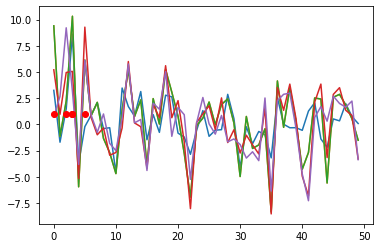

2021-01-30 16:58:40,554 P92522 INFO acc: 0.8
2021-01-30 16:58:40,565 P92522 INFO Epoch: 81, loss: 0.000
2021-01-30 16:58:40,593 P92522 INFO ploss: 0.0001, nloss: 0.6802, pos: 9.3461, neg: -0.2555


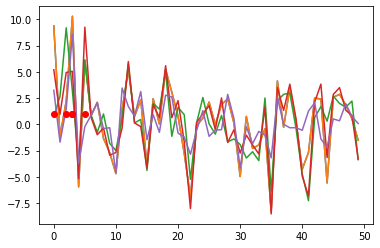

2021-01-30 16:58:40,789 P92522 INFO acc: 0.8
2021-01-30 16:58:40,801 P92522 INFO Epoch: 82, loss: 0.000
2021-01-30 16:58:40,827 P92522 INFO ploss: 0.0001, nloss: 1.3892, pos: 9.3320, neg: 1.0144


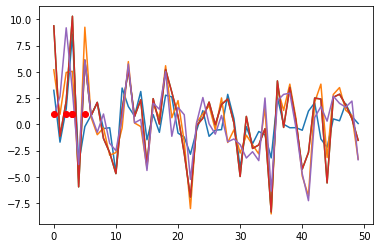

2021-01-30 16:58:41,014 P92522 INFO acc: 0.8
2021-01-30 16:58:41,024 P92522 INFO Epoch: 83, loss: 0.000
2021-01-30 16:58:41,052 P92522 INFO ploss: 0.0001, nloss: 1.1141, pos: 9.3178, neg: 0.1850


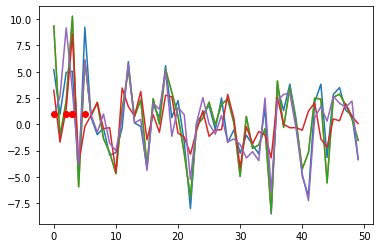

2021-01-30 16:58:41,266 P92522 INFO acc: 0.8
2021-01-30 16:58:41,275 P92522 INFO Epoch: 84, loss: 0.000
2021-01-30 16:58:41,303 P92522 INFO ploss: 0.0001, nloss: 1.3575, pos: 9.3037, neg: 0.8945


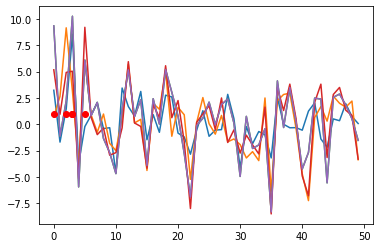

2021-01-30 16:58:41,500 P92522 INFO acc: 0.8
2021-01-30 16:58:41,510 P92522 INFO Epoch: 85, loss: 0.000
2021-01-30 16:58:41,536 P92522 INFO ploss: 0.0001, nloss: 1.3638, pos: 9.2896, neg: 0.7136


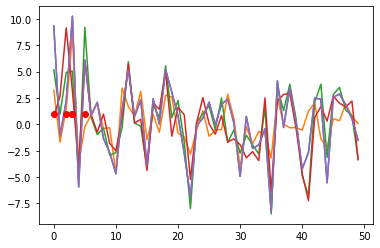

2021-01-30 16:58:41,703 P92522 INFO acc: 0.8
2021-01-30 16:58:41,713 P92522 INFO Epoch: 86, loss: 0.000
2021-01-30 16:58:41,740 P92522 INFO ploss: 0.0001, nloss: 1.1804, pos: 9.2754, neg: 0.0610


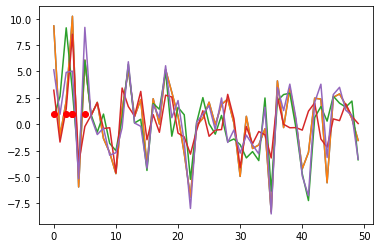

2021-01-30 16:58:41,915 P92522 INFO acc: 0.8
2021-01-30 16:58:41,926 P92522 INFO Epoch: 87, loss: 0.000
2021-01-30 16:58:41,953 P92522 INFO ploss: 0.0001, nloss: 0.4909, pos: 9.2613, neg: -0.7936


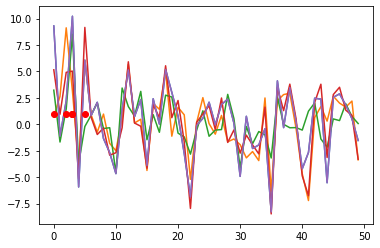

2021-01-30 16:58:42,152 P92522 INFO acc: 0.8
2021-01-30 16:58:42,162 P92522 INFO Epoch: 88, loss: 0.000
2021-01-30 16:58:42,189 P92522 INFO ploss: 0.0001, nloss: 2.1102, pos: 9.2472, neg: 1.8989


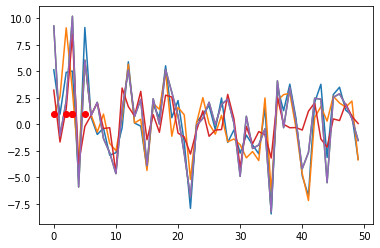

2021-01-30 16:58:42,368 P92522 INFO acc: 0.8
2021-01-30 16:58:42,377 P92522 INFO Epoch: 89, loss: 0.000
2021-01-30 16:58:42,403 P92522 INFO ploss: 0.0001, nloss: 1.2059, pos: 9.2331, neg: 0.7420


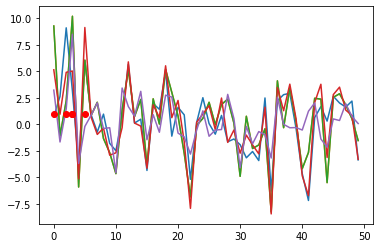

2021-01-30 16:58:42,589 P92522 INFO acc: 0.8
2021-01-30 16:58:42,600 P92522 INFO Epoch: 90, loss: 0.000
2021-01-30 16:58:42,627 P92522 INFO ploss: 0.0001, nloss: 1.1962, pos: 9.2191, neg: 0.6357


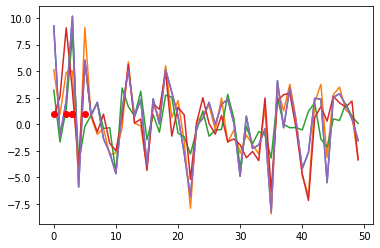

2021-01-30 16:58:42,813 P92522 INFO acc: 0.8
2021-01-30 16:58:42,823 P92522 INFO Epoch: 91, loss: 0.000
2021-01-30 16:58:42,851 P92522 INFO ploss: 0.0001, nloss: 0.9257, pos: 9.2051, neg: 0.2708


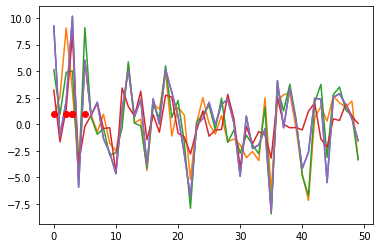

2021-01-30 16:58:43,034 P92522 INFO acc: 0.8
2021-01-30 16:58:43,043 P92522 INFO Epoch: 92, loss: 0.000
2021-01-30 16:58:43,069 P92522 INFO ploss: 0.0001, nloss: 1.1590, pos: 9.1911, neg: -0.3778


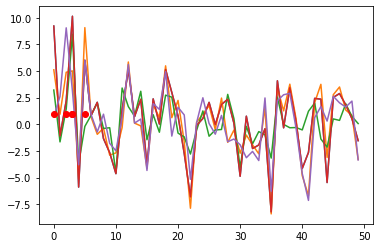

2021-01-30 16:58:43,240 P92522 INFO acc: 0.8
2021-01-30 16:58:43,249 P92522 INFO Epoch: 93, loss: 0.000
2021-01-30 16:58:43,278 P92522 INFO ploss: 0.0001, nloss: 0.8798, pos: 9.1771, neg: -0.0381


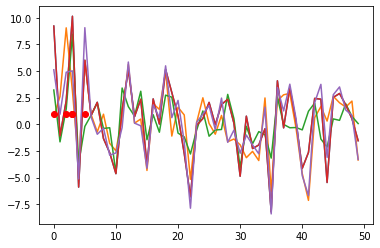

2021-01-30 16:58:43,476 P92522 INFO acc: 0.8
2021-01-30 16:58:43,485 P92522 INFO Epoch: 94, loss: 0.000
2021-01-30 16:58:43,510 P92522 INFO ploss: 0.0001, nloss: 1.4127, pos: 9.1632, neg: 0.5136


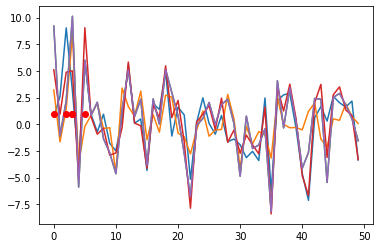

2021-01-30 16:58:43,703 P92522 INFO acc: 0.8
2021-01-30 16:58:43,712 P92522 INFO Epoch: 95, loss: 0.000
2021-01-30 16:58:43,737 P92522 INFO ploss: 0.0001, nloss: 0.8739, pos: 9.1493, neg: 0.2641


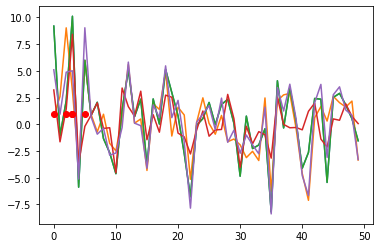

2021-01-30 16:58:44,073 P92522 INFO acc: 0.8
2021-01-30 16:58:44,081 P92522 INFO Epoch: 96, loss: 0.000
2021-01-30 16:58:44,110 P92522 INFO ploss: 0.0001, nloss: 0.5721, pos: 9.1355, neg: -0.4281


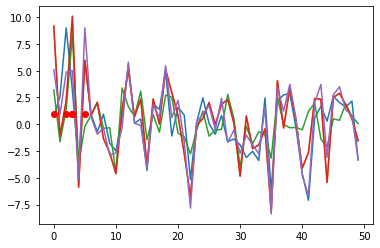

2021-01-30 16:58:44,371 P92522 INFO acc: 0.8
2021-01-30 16:58:44,385 P92522 INFO Epoch: 97, loss: 0.000
2021-01-30 16:58:44,421 P92522 INFO ploss: 0.0001, nloss: 1.3625, pos: 9.1217, neg: 0.8641


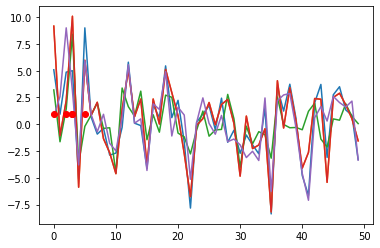

2021-01-30 16:58:44,627 P92522 INFO acc: 0.8
2021-01-30 16:58:44,638 P92522 INFO Epoch: 98, loss: 0.000
2021-01-30 16:58:44,672 P92522 INFO ploss: 0.0001, nloss: 1.1649, pos: 9.1079, neg: 0.7157


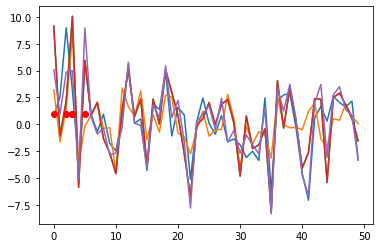

2021-01-30 16:58:44,884 P92522 INFO acc: 0.8
2021-01-30 16:58:44,894 P92522 INFO Epoch: 99, loss: 0.000
2021-01-30 16:58:44,922 P92522 INFO ploss: 0.0001, nloss: 1.1883, pos: 9.0942, neg: 0.4195


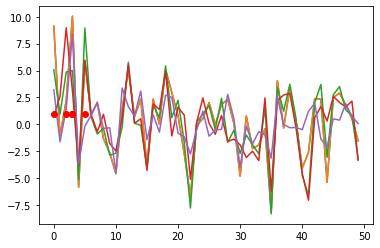

2021-01-30 16:58:45,134 P92522 INFO acc: 0.8
2021-01-30 16:58:45,142 P92522 INFO Epoch: 100, loss: 0.000
2021-01-30 16:58:45,170 P92522 INFO ploss: 0.0001, nloss: 1.4119, pos: 9.0805, neg: 0.6306


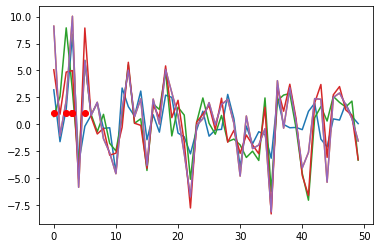

2021-01-30 16:58:45,407 P92522 INFO acc: 0.8
2021-01-30 16:58:45,417 P92522 INFO Epoch: 101, loss: 0.000
2021-01-30 16:58:45,446 P92522 INFO ploss: 0.0001, nloss: 1.0873, pos: 9.0669, neg: 0.4404


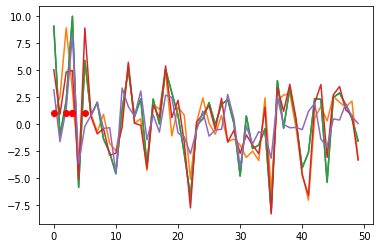

2021-01-30 16:58:45,627 P92522 INFO acc: 0.8
2021-01-30 16:58:45,637 P92522 INFO Epoch: 102, loss: 0.000
2021-01-30 16:58:45,669 P92522 INFO ploss: 0.0001, nloss: 0.6104, pos: 9.0533, neg: -0.4236


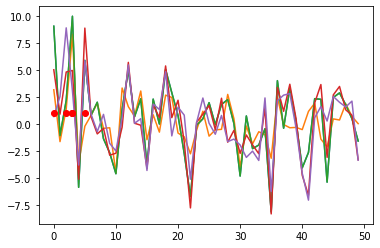

2021-01-30 16:58:45,870 P92522 INFO acc: 0.8
2021-01-30 16:58:45,880 P92522 INFO Epoch: 103, loss: 0.000
2021-01-30 16:58:45,906 P92522 INFO ploss: 0.0001, nloss: 0.9708, pos: 9.0398, neg: 0.1798


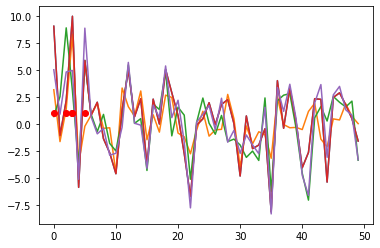

2021-01-30 16:58:46,102 P92522 INFO acc: 0.8
2021-01-30 16:58:46,112 P92522 INFO Epoch: 104, loss: 0.000
2021-01-30 16:58:46,141 P92522 INFO ploss: 0.0001, nloss: 0.8912, pos: 9.0264, neg: -0.6412


KeyboardInterrupt: 

In [18]:
# training
encoder.fit(
            train_iterator,
            test_iterator=test_iterator.loader,
            test_labels=None,
            **params
        )
encoder.save_encoder()

In [10]:
# test_labels = window_dict["test_labels"][:, -1]
score_dict = encoder.score(test_iterator.loader, window_dict["test_labels"],)

2021-01-29 12:40:52,360 P71268 INFO Evaluating


RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

In [ ]:
plt.plot(score_dict["score"])

In [43]:
# def reconstruction_loader(loader, encoder):
train_iterator_non_shuffle = WindowIterator(window_dict["train_windows"],
                                            batch_size=params["batch_size"], shuffle=False)
loader = train_iterator_non_shuffle.loader

# loader = test_iterator.loader
# encoder = encoder.eval()
with torch.no_grad():
    recst_list = []
    real_list = []
    loss = 0
    for batch in loader:
        batch = batch.to(encoder.device)
        return_dict = encoder(batch)
        # diff = return_dict["diff"].max(dim=-1)[0] # chose the most anomaous ts
        recst = return_dict["recst"]  # chose the most anomaous ts
        recst_list.append(recst)
        real_list.append(return_dict["y"])
        loss += return_dict["loss"].item()
print(loss / len(loader))
recst_list = torch.cat(recst_list).cpu().numpy()
real_list = torch.cat(real_list).cpu().numpy()
diff_list = recst_list-real_list

2021-01-29 16:38:46,364 P76806 INFO pos: 8.406208038330078, neg: -1.5817941427230835
2021-01-29 16:38:46,381 P76806 INFO acc: 0.31866776315789475
2021-01-29 16:38:46,464 P76806 INFO pos: 8.406506538391113, neg: -1.635750651359558
2021-01-29 16:38:46,467 P76806 INFO acc: 0.3223684210526316
2021-01-29 16:38:46,549 P76806 INFO pos: 8.138069152832031, neg: -1.6136516332626343
2021-01-29 16:38:46,567 P76806 INFO acc: 0.3100328947368421
2021-01-29 16:38:46,655 P76806 INFO pos: 8.176024436950684, neg: -1.4348167181015015
2021-01-29 16:38:46,675 P76806 INFO acc: 0.2935855263157895
2021-01-29 16:38:46,750 P76806 INFO pos: 8.155011177062988, neg: -1.7156075239181519
2021-01-29 16:38:46,772 P76806 INFO acc: 0.29317434210526316
2021-01-29 16:38:46,858 P76806 INFO pos: 8.068547248840332, neg: -1.3579258918762207
2021-01-29 16:38:46,861 P76806 INFO acc: 0.29399671052631576
2021-01-29 16:38:46,951 P76806 INFO pos: 8.07094669342041, neg: -1.319493293762207
2021-01-29 16:38:46,954 P76806 INFO acc: 0.30

0.21231671209846223


In [12]:
return_dict["recst"].shape

torch.Size([57, 38])

In [13]:
print(recst_list.shape)
print(real_list.shape)
print(diff_list.shape)

(889, 38)
(889, 38)
(889, 38)


In [45]:
real_list[0, 0:10], recst_list[0, 0:10]

(array([ 6.,  3.,  8.,  7.,  0., 91., 96.,  0., 12.,  0.], dtype=float32),
 array([19, 31, 77, 10,  0, 91, 44,  0, 31,  0]))

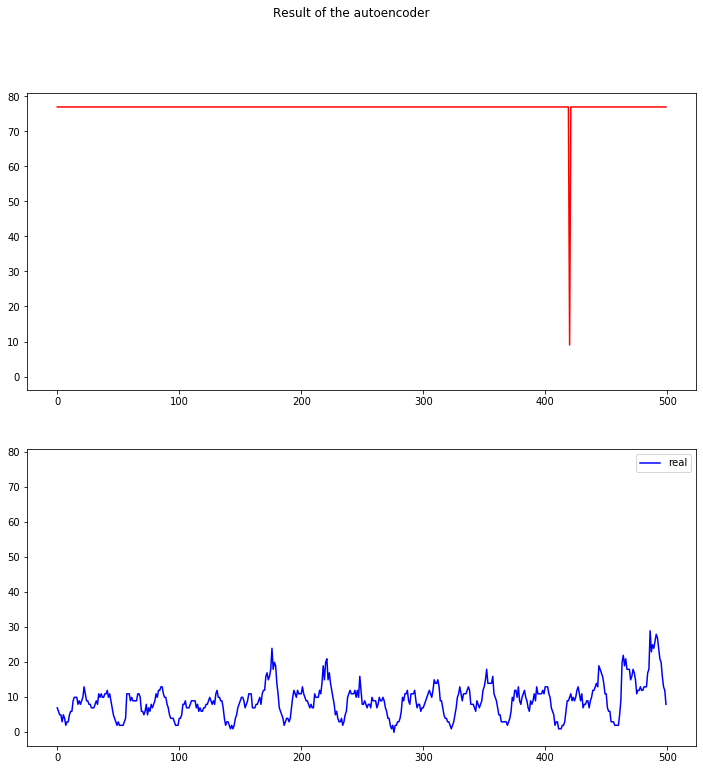

In [44]:
dims = [0,1]
fig, ax = plt.subplots(nrows=len(dims), sharey=True, figsize=(12,12))
i=20
# for i in range(len(dims)):
# ax[0].plot(recst, 'r', label='reconstruction')
# ax[0].legend(loc='best')
ax[0].plot(recst_list[0:500,i].reshape(-1), 'r', label='recst')
ax[1].plot(real_list[0:500,i].reshape(-1), 'b', label='real')
# ax[1].plot(diff_list[15000:-1].reshape(-1), 'b', label='real')
# ax[1].plot(window_dict["test_labels"][15000:, -1].reshape(-1)+0.3, 'r', label='real')
# ax[0].legend(loc='best')
# ax[1].legend(loc='best')

# ax[2].plot(recst, 'r', label='reconstruction')
# ax[2].plot(real, 'b', label='real')
# ax[2].legend(loc='best')

# ax[3].plot(diff, 'g', label='ecart')
# ax[3].legend(loc='best')

plt.legend()
plt.suptitle("Result of the autoencoder")
plt.show()

In [23]:
torch.randint(1,3, (3,))

tensor([2, 1, 1])